Alpha-Beta Regression

In [3]:
import pandas as pd
import numpy as np

from Bio.PDB import *
import os
import numpy as np
import collections

from scipy.spatial import distance
from pygsp import graphs, features
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression



from Bio import BiopythonWarning
from Bio.PDB.PDBExceptions import PDBConstructionWarning
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore', BiopythonWarning)
    warnings.simplefilter('ignore', PDBConstructionWarning)

In [4]:
amino_lookup = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
amino_molecular_mass = {'A': 89.09404, 'R': 174.20274, 'N': 132.11904, 'D': 133.10384, 'C': 121.15404,
                        'Q': 146.14594, 'E': 147.13074, 'G': 75.06714, 'H': 155.15634, 'I': 131.17464,
                        'L': 131.17464, 'K': 146.18934, 'M': 149.20784, 'F': 165.19184, 'P': 115.13194,
                        'S': 105.09344, 'T': 119.12034, 'W': 204.22844, 'Y': 181.19124, 'V': 117.14784}
amino_hydrophobicity = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
                        'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
                        'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
                        'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2}

In [5]:
def crawl_pdb(path):
    '''This funciton reads pdb files and stores there distance matrix and sequence'''
    parser = PDBParser()
    pdb_files = sorted(os.listdir(path))
    pdbinfo_dict = dict()
    for pdb in pdb_files:
        info = dict()
        info[id] = pdb
        structure = parser.get_structure('pdb_file', path + '/' + pdb + '/' + pdb.split('_')[1].upper()+'.pdb' ) # + '/' + pdb + '.pdb'
        coordinates = []
        labels = list()
        for model in structure:
            for chain in model:
                for residue in chain:
                    try:
                        assert residue.get_resname() not in ['HOH', ' CA']
                        coordinates.append(residue['CA'].get_coord())
                        labels.append(residue.get_resname())

                    except :
                        pass
                break  ## working on chain id A only
            break      ## Working on model id 0 only
        coords = np.asmatrix(coordinates)
        distance_matrix = distance.squareform(distance.pdist(coords))
        info['coords'] = coords
        info['distance_matrix'] = distance_matrix
        info['sequence'] = ''.join([amino_lookup[s] for s in labels])
        pdbinfo_dict[pdb] = info
    return pdbinfo_dict


def get_graph(distance_matrix, network_type, rig_cutoff=8, lin_cutoff=12):
    distance_matrix[distance_matrix >= rig_cutoff] = 0
    if network_type == 'rig-boolean':
        distance_matrix[distance_matrix > 0] = 1
    elif network_type == 'weighted-rig':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    distance_matrix[i, j] = abs(j - i)
    elif network_type == 'weighted-lin':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    if abs(i - j) >= lin_cutoff or abs(i - j) == 1:
                        distance_matrix[i, j] = abs(i - j)
                    else:
                        distance_matrix[i, j] = 0
    elif network_type == 'lin':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    if abs(i - j) >= lin_cutoff or abs(i - j) == 1:
                        distance_matrix[i, j] = 1
                    else:
                        distance_matrix[i, j] = 0
    else:
        print('Invalid Choice! ' + network_type)
        return None
    G = graphs.Graph(distance_matrix, lap_type='normalized')
    G.compute_fourier_basis()
    return G


def get_signal(G, seq, signal):
    if signal == 'molecular_weight':
        s = np.asarray([amino_molecular_mass[aa] for aa in seq])
    elif signal == 'hydrophobicity':
        s = np.asarray([amino_hydrophobicity[aa] for aa in seq])
    elif signal == 'node_degree':
        s = G.d
    elif signal == 'node_weighted_degree':
        adj = G.W.todense()
        s = np.ravel(adj.sum(axis=0)) / 2
    elif signal == 'avg_adj_degree':
        s = features.compute_avg_adj_deg(G)
        s = np.ravel(s)
    elif signal == 'clustering_coeff':
        N = nx.from_scipy_sparse_matrix(G.W)
        s = nx.clustering(N)
        s = np.asarray(list(s.values()))
    elif signal == 'aaalpha_helix':
        s = eng.aaalpha_helixfasman(seq)
        s = np.array(s._data)
    elif signal == 'residue_count':
        residue_counts = collections.Counter(seq)
        s = np.asarray([residue_counts[s] for s in seq])
    elif signal == 'centrality':
        N = nx.from_scipy_sparse_matrix(G.W)
        s = list(nx.betweenness_centrality(N).values())
        s = np.array(s)
    elif signal == 'page_rank':
        N = nx.from_scipy_sparse_matrix(G.W)
        s = list(nx.algorithms.link_analysis.pagerank(N).values())
        s = np.array(s)
    else:
        print ('Invalid Choice! ' + signal)
    return s


def get_filtered_signal(G, signal, cutoff):
    signal_hat = G.gft(signal)
    signal_filtered_hat = np.zeros_like(signal_hat)
    signal_filtered_hat[G.e < G.lmax * cutoff] = signal_hat[G.e < G.lmax * cutoff]
    signal_filtered = G.igft(signal_filtered_hat)
    return signal_filtered

In [6]:
# pdbinfo_dict_alpha = crawl_pdb('../data/alpha/')
# pdbinfo_dict_beta = crawl_pdb('../data/beta/')
pdbinfo_dict = crawl_pdb('../data/SDTSF_RIG_LIN/')

/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstruction

/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'O' for Atom (name=OE1) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'O' for Atom (name=OE2) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element '2'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element '2'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBCons

/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=CE1) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=CE2) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=CZ) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'N' for Atom (name=NE2) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBCo

/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'H' for Atom (name=1HD) with given element '12'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'H' for Atom (name=2HD) with given element '12'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'H' for Atom (name=1HZ) with given element '12'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'H' for Atom (name=2HZ) with given element '12'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: 

/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstruc

/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstruc

In [7]:
signals = ['molecular_weight', 'hydrophobicity', 'node_degree', 'node_weighted_degree', 
           'residue_count', 'clustering_coeff', 'centrality', 'page_rank']

In [8]:
lfc_cutoff = 0.42
model = 'weighted-rig'
print (lfc_cutoff, end=' : ')
gsp_features = pd.DataFrame(columns=signals + ['class'])

for pdb in pdbinfo_dict.keys():
#         print (pdb, end=', ')
    row = []
    if pdb.startswith('A_'): c = 1
    elif pdb.startswith('B_'): c = -1
    else: c = 0
    G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    for signal_name in signals:
        signal = get_signal(G, pdbinfo_dict[pdb]['sequence'], signal=signal_name)
        gftsignal = G.gft(signal)
        signal_hat = gftsignal
        value = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        row.append(value)

    row.append(c)
    gsp_features.loc[pdb] = row

X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

0.42 : 0.5307509306958158


## Lasso

In [9]:
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=10, random_state=0).fit(X, y)
reg.score(X, y)

0.4574745766967788

## Visualization

In [10]:
import seaborn as sns
sns.set_palette('viridis')

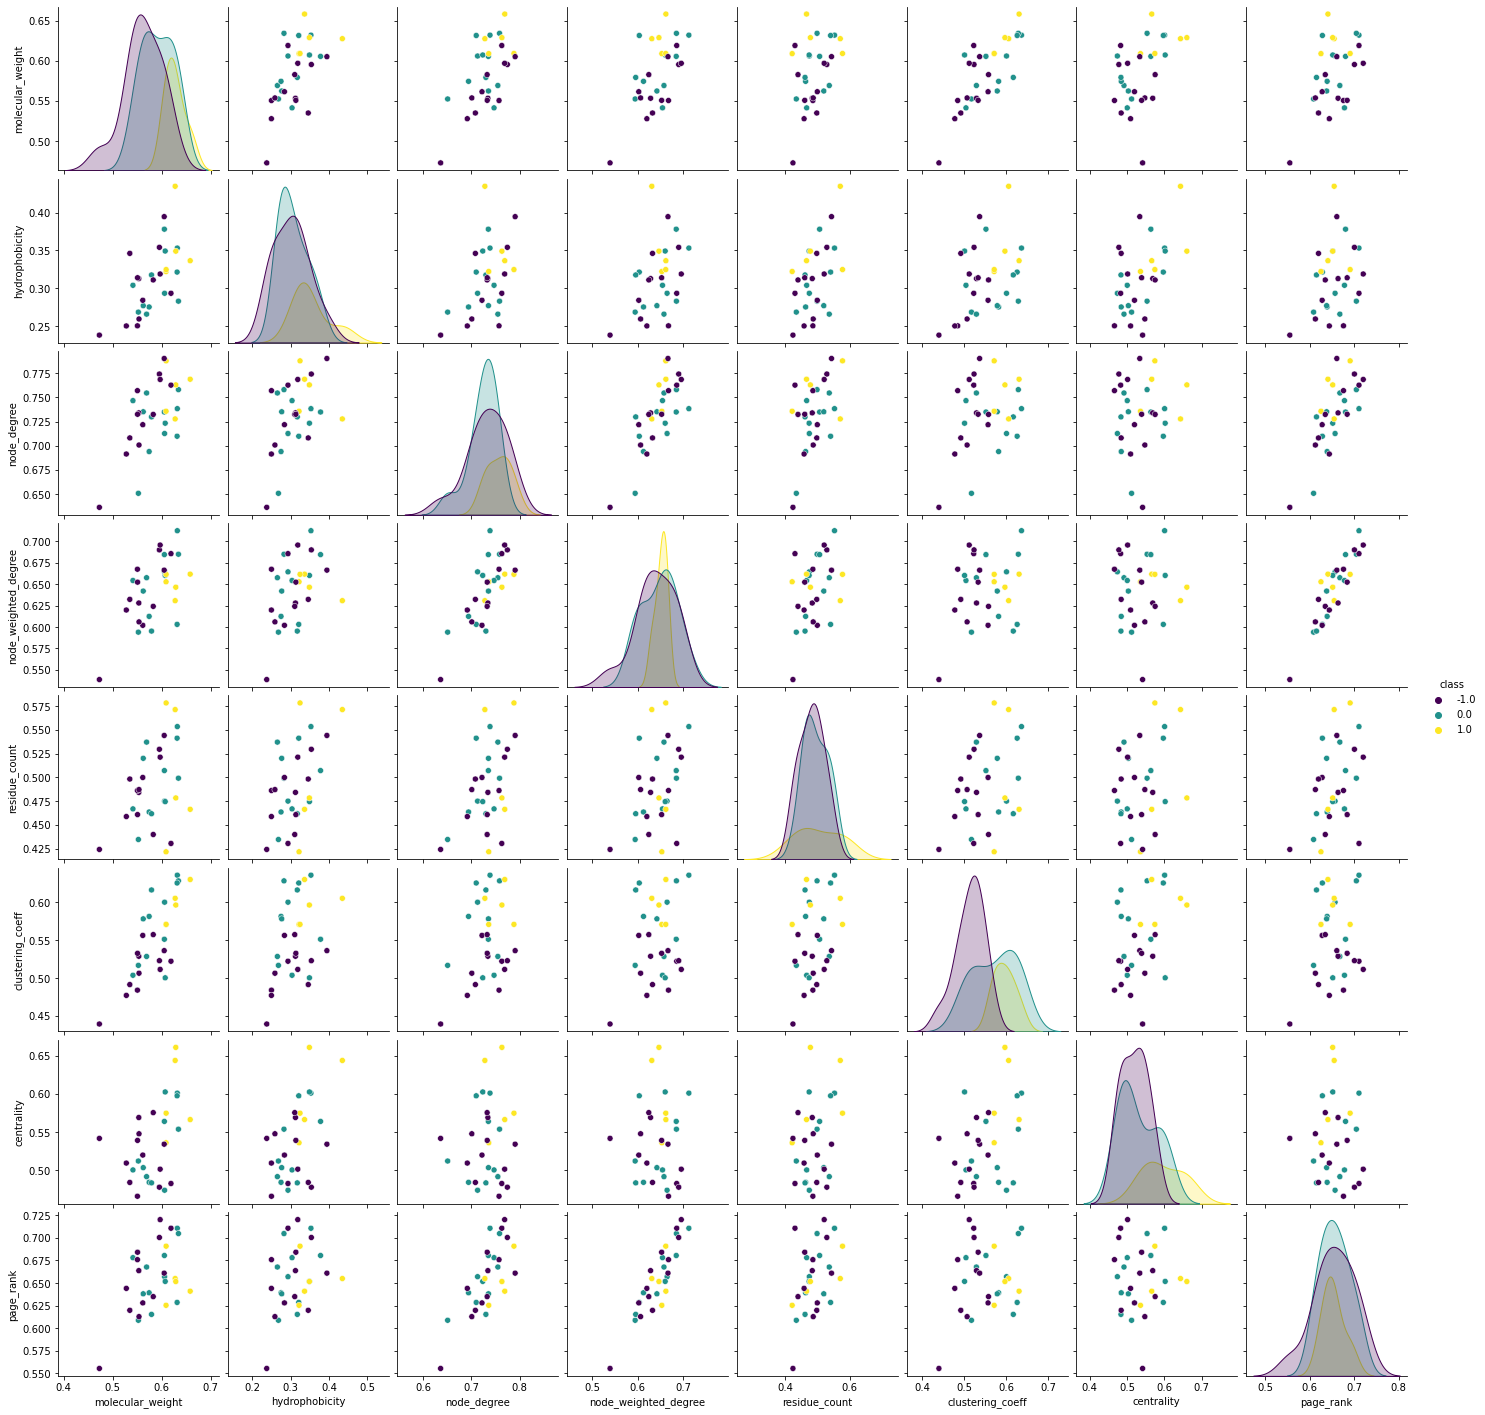

In [11]:
sns.pairplot(gsp_features, hue='class', palette='viridis')

## Binary Classification

In [13]:
gsp_features_short = gsp_features[gsp_features['class'] != 0]

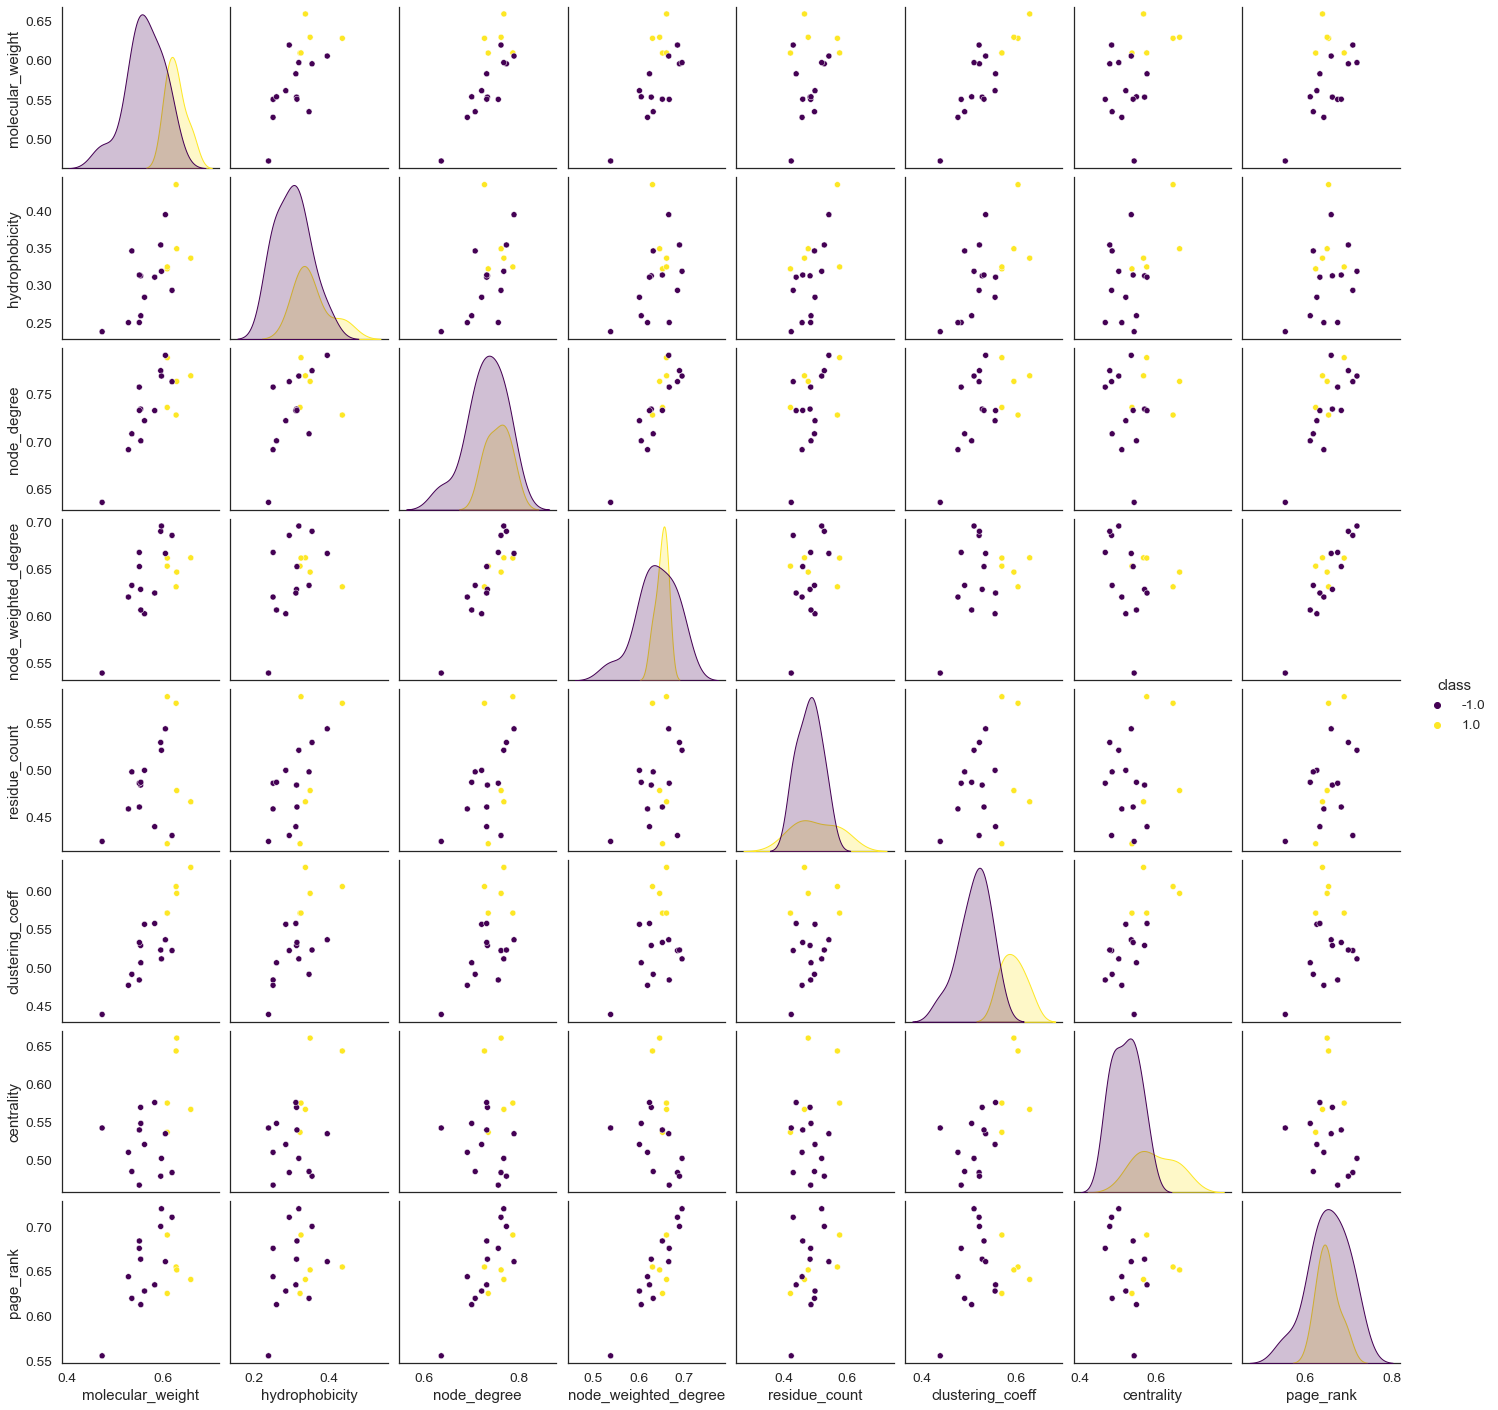

In [20]:
sns.set(font_scale=1.25)
sns.set_style("white")
g = sns.pairplot(gsp_features_short, hue='class', palette='viridis')
# g._legend.remove()
sns.despine()

### Linear Regression

In [14]:
lrs = LinearRegression()
Xs = gsp_features_short[gsp_features_short.columns.difference(['class'])]
ys = gsp_features_short['class']


lrs.fit(Xs, ys)
lrs.score(Xs, ys)

0.789944405923728

In [22]:
lrs.coef_

array([ 10.48662137,   8.82328801,  -8.250435  ,   4.20713561,
       -15.56508263,  33.91328273, -19.22706025,   7.613028  ])

In [23]:
X.columns

Index(['centrality', 'clustering_coeff', 'hydrophobicity', 'molecular_weight',
       'node_degree', 'node_weighted_degree', 'page_rank', 'residue_count'],
      dtype='object')

## Cross Validation

In [24]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
n_samples = Xs.shape[0]
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

# from sklearn.model_selection import cross_val_score
clf = LinearRegression()
scores = cross_val_score(clf, Xs, ys, cv=cv)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.02 (+/- 0.87)


In [25]:

scores

array([ 0.85752512,  0.09671789,  0.        , -0.13157887,  0.        ,
       -0.08952658,  0.        , -0.30090187,  0.        , -1.38823174,
        0.07830889,  0.33318186,  0.50676448,  0.        ,  0.32686906,
        0.        ,  0.        , -0.00408524,  0.56959089, -0.41972461])

# Lasso Regression

In [15]:
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=5, random_state=0, verbose=True).fit(Xs, ys)
reg.score(Xs, ys)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


0.6471311205691346